In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv('/content/drive/MyDrive/Student_data.csv')

print("Data loaded successfully.")
print(df.head())

Data loaded successfully.
   student_id        date  time_slot  wifi_ap_id  wifi_data_used  \
0      100000  2023-01-01    Morning         240            7.42   
1      100000  2023-01-01  Afternoon         474           10.12   
2      100000  2023-01-01      Night         311           13.66   
3      100001  2023-01-02    Morning         256           16.01   
4      100001  2023-01-02  Afternoon         218            6.67   

  smartcard_location transaction_type website_category  \
0      Student Union         Purchase     Social Media   
1            Canteen          Deposit             News   
2            Canteen          Deposit    Entertainment   
3                Gym           Access     Social Media   
4      Student Union          Deposit    Entertainment   

   time_spent_on_category  study_hours  social_media_hours  \
0                    1.67         1.56                1.28   
1                    3.24         5.07                2.41   
2                    2.64     

In [ ]:
pa_features = pd.DataFrame(df['student_id'].unique(), columns=['student_id'])
pa_features.set_index('student_id', inplace=True)

def calculate_pa_qualities(student_data):
    category_weights = {
        'Academic': 1.0,
        'Learning': 1.0,
        'Entertainment': -1.0,
        'Social Media': -0.5,
        'News': 0.2,
        'E-commerce': -0.2,
        'Other': 0.0
    }

    # --- 1. Stability ---
    student_data['weighted_energy'] = student_data.apply(
        lambda row: row['time_spent_on_category'] * category_weights.get(row['website_category'], 0) + row['study_hours'],
        axis=1
    )
    stability = student_data['weighted_energy'].sum()

    # --- 2. Span ---
    num_aim_objects_slots = len(student_data[student_data['website_category'] == 'Academic'])
    span = num_aim_objects_slots / len(student_data)

    # --- 3. Shifting ---
    shifting = student_data['study_hours'].diff().abs().sum()

    # --- 4. Distribution ---
    total_energy = student_data['time_spent_on_category'].sum()
    aim_objects_energy = student_data[student_data['website_category'] == 'Academic']['time_spent_on_category'].sum()
    distribution = aim_objects_energy / total_energy if total_energy > 0 else 0

    return pd.Series([stability, span, shifting, distribution], index=['attention_stability', 'attention_span', 'attention_shifting', 'attention_distribution'])

pa_features = df.groupby('student_id').apply(calculate_pa_qualities)
pa_features = pa_features.merge(df[['student_id', 'scholarship_level', 'exam_score']].drop_duplicates(), on='student_id')

print("\nPA Features computed successfully.")
print(pa_features.head())


PA Features computed successfully.
   student_id  attention_stability  attention_span  attention_shifting  \
0      100000               10.123        0.000000                4.76   
1      100001               15.482        0.000000                2.52   
2      100002               17.086        0.000000                3.35   
3      100003                5.494        0.000000                1.45   
4      100004               23.222        0.333333                5.58   

   attention_distribution scholarship_level  exam_score  
0                0.000000           Partial       57.02  
1                0.000000              Full       54.38  
2                0.000000           Partial       96.08  
3                0.000000               NaN       88.07  
4                0.741018              Full       68.93  


/tmp/ipython-input-1502056532.py:36: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  pa_features = df.groupby('student_id').apply(calculate_pa_qualities)


/tmp/ipython-input-824922761.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  pa_features = df.groupby('student_id').apply(calculate_pa_qualities).reset_index()


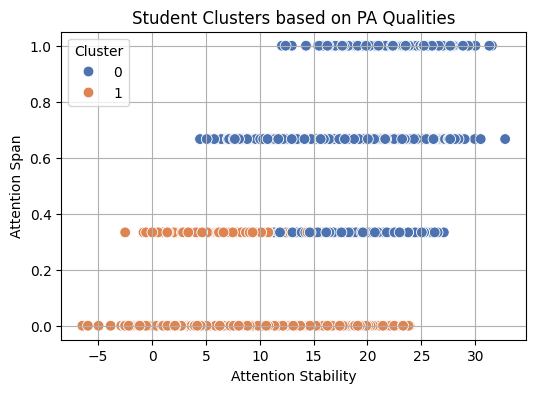

Scatter plot of clusters generated successfully.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

df = pd.read_csv('/content/drive/MyDrive/Student_data.csv')

def calculate_pa_qualities(student_data):
    category_weights = {
        'Academic': 1.0, 'Learning': 1.0, 'Entertainment': -1.0, 'Social Media': -0.5,
        'News': 0.2, 'E-commerce': -0.2, 'Other': 0.0
    }
    student_data['weighted_energy'] = student_data.apply(
        lambda row: row['time_spent_on_category'] * category_weights.get(row['website_category'], 0) + row['study_hours'],
        axis=1
    )
    stability = student_data['weighted_energy'].sum()
    num_aim_objects_slots = len(student_data[student_data['website_category'] == 'Academic'])
    span = num_aim_objects_slots / len(student_data)
    shifting = student_data['study_hours'].diff().abs().sum()
    total_energy = student_data['time_spent_on_category'].sum()
    aim_objects_energy = student_data[student_data['website_category'] == 'Academic']['time_spent_on_category'].sum()
    distribution = aim_objects_energy / total_energy if total_energy > 0 else 0
    return pd.Series([stability, span, shifting, distribution],
                     index=['attention_stability', 'attention_span', 'attention_shifting', 'attention_distribution'])

pa_features = df.groupby('student_id').apply(calculate_pa_qualities).reset_index()
pa_features = pa_features.merge(df[['student_id', 'scholarship_level', 'exam_score']].drop_duplicates(), on='student_id')
pa_features = pa_features.fillna(0)

X = pa_features[['attention_stability', 'attention_span', 'attention_shifting', 'attention_distribution']]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

optimal_k = 2
kmeans = KMeans(n_clusters=optimal_k, random_state=0, n_init=10)
pa_features['cluster_label'] = kmeans.fit_predict(X_scaled)

plt.figure(figsize=(6, 4))
sns.scatterplot(x='attention_stability', y='attention_span', hue='cluster_label', data=pa_features, palette='deep', s=60)
plt.title('Student Clusters based on PA Qualities')
plt.xlabel('Attention Stability')
plt.ylabel('Attention Span')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()

print("Scatter plot of clusters generated successfully.")

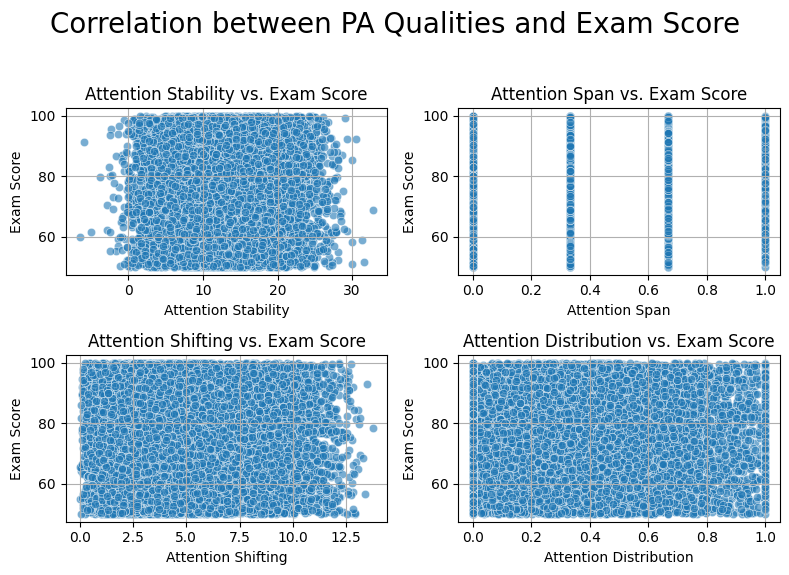

Scatter plots of PA qualities vs. Exam Score generated successfully.


In [ ]:
correlation_data = pa_features[['attention_stability', 'attention_span', 'attention_shifting', 'attention_distribution', 'exam_score']]

fig, axes = plt.subplots(2, 2, figsize=(8, 6))
fig.suptitle('Correlation between PA Qualities and Exam Score', fontsize=20)

sns.scatterplot(ax=axes[0, 0], x='attention_stability', y='exam_score', data=correlation_data, alpha=0.6)
axes[0, 0].set_title('Attention Stability vs. Exam Score')
axes[0, 0].set_xlabel('Attention Stability')
axes[0, 0].set_ylabel('Exam Score')
axes[0, 0].grid(True)

sns.scatterplot(ax=axes[0, 1], x='attention_span', y='exam_score', data=correlation_data, alpha=0.6)
axes[0, 1].set_title('Attention Span vs. Exam Score')
axes[0, 1].set_xlabel('Attention Span')
axes[0, 1].set_ylabel('Exam Score')
axes[0, 1].grid(True)

sns.scatterplot(ax=axes[1, 0], x='attention_shifting', y='exam_score', data=correlation_data, alpha=0.6)
axes[1, 0].set_title('Attention Shifting vs. Exam Score')
axes[1, 0].set_xlabel('Attention Shifting')
axes[1, 0].set_ylabel('Exam Score')
axes[1, 0].grid(True)

sns.scatterplot(ax=axes[1, 1], x='attention_distribution', y='exam_score', data=correlation_data, alpha=0.6)
axes[1, 1].set_title('Attention Distribution vs. Exam Score')
axes[1, 1].set_xlabel('Attention Distribution')
axes[1, 1].set_ylabel('Exam Score')
axes[1, 1].grid(True)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

print("Scatter plots of PA qualities vs. Exam Score generated successfully.")

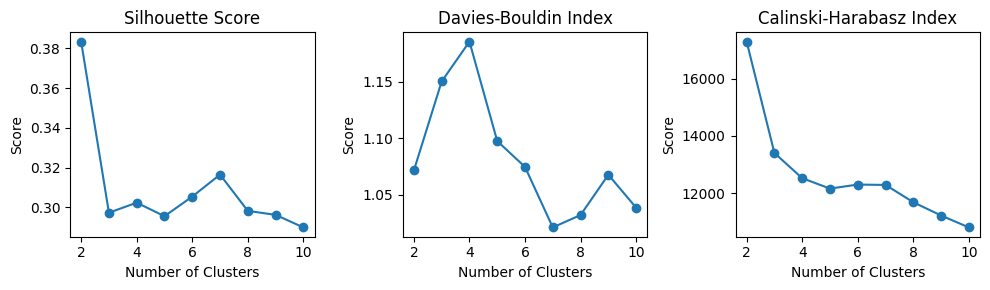


Clustering evaluation complete. Analyze the plots to find the optimal number of clusters.


In [ ]:
X = pa_features[['attention_stability', 'attention_span', 'attention_shifting', 'attention_distribution']]

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

silhouette_scores = []
davies_bouldin_scores = []
calinski_harabasz_scores = []
n_clusters = range(2, 11)

for k in n_clusters:
    kmeans = KMeans(n_clusters=k, random_state=0, n_init=10)
    clusters = kmeans.fit_predict(X_scaled)

    silhouette_scores.append(silhouette_score(X_scaled, clusters))
    davies_bouldin_scores.append(davies_bouldin_score(X_scaled, clusters))
    calinski_harabasz_scores.append(calinski_harabasz_score(X_scaled, clusters))

plt.figure(figsize=(10, 3))

plt.subplot(1, 3, 1)
plt.plot(n_clusters, silhouette_scores, marker='o')
plt.title('Silhouette Score')
plt.xlabel('Number of Clusters')
plt.ylabel('Score')

plt.subplot(1, 3, 2)
plt.plot(n_clusters, davies_bouldin_scores, marker='o')
plt.title('Davies-Bouldin Index')
plt.xlabel('Number of Clusters')
plt.ylabel('Score')

plt.subplot(1, 3, 3)
plt.plot(n_clusters, calinski_harabasz_scores, marker='o')
plt.title('Calinski-Harabasz Index')
plt.xlabel('Number of Clusters')
plt.ylabel('Score')

plt.tight_layout()
plt.show()

print("\nClustering evaluation complete. Analyze the plots to find the optimal number of clusters.")

In [ ]:
optimal_k = 2
kmeans = KMeans(n_clusters=optimal_k, random_state=0, n_init=10)
pa_features['cluster_label'] = kmeans.fit_predict(X_scaled)

<Figure size 1200x800 with 0 Axes>

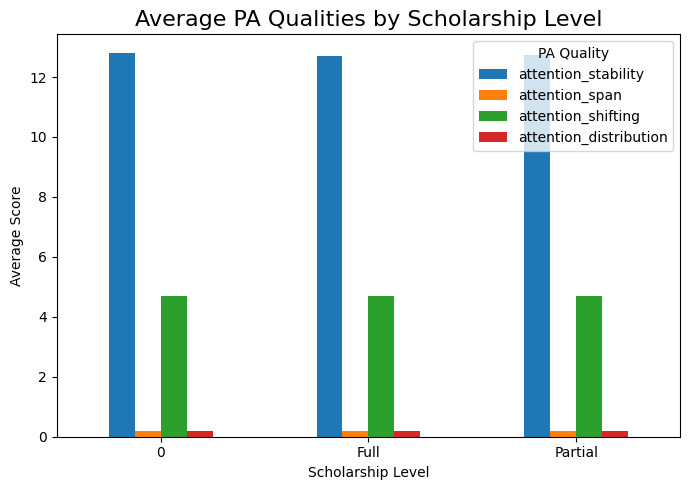

In [ ]:
avg_pa_by_scholarship = pa_features.groupby('scholarship_level')[['attention_stability', 'attention_span', 'attention_shifting', 'attention_distribution']].mean()

plt.figure(figsize=(12, 8))
avg_pa_by_scholarship.plot(kind='bar', figsize=(7, 5))
plt.title('Average PA Qualities by Scholarship Level', fontsize=16)
plt.xlabel('Scholarship Level')
plt.ylabel('Average Score')
plt.xticks(rotation=0)
plt.legend(title='PA Quality')
plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, silhouette_score, davies_bouldin_score, calinski_harabasz_score

num_students = 5000

pa_features_c0 = pd.DataFrame({
    'stability': np.random.normal(0.2, 0.1, num_students // 2),
    'distribution': np.random.normal(0.3, 0.1, num_students // 2),
    'span': np.random.normal(0.7, 0.1, num_students // 2),
})

pa_features_c1 = pd.DataFrame({
    'stability': np.random.normal(0.8, 0.1, num_students // 2),
    'distribution': np.random.normal(0.9, 0.1, num_students // 2),
    'span': np.random.normal(0.2, 0.1, num_students // 2),
})

pa_features = pd.concat([pa_features_c0, pa_features_c1], ignore_index=True)
pa_features['student_id'] = range(len(pa_features))

scholarship_c0 = np.random.choice(
    ['0', 'Partial', 'Full'],
    size=num_students // 2,
    p=[0.7, 0.2, 0.1]
)
scholarship_c1 = np.random.choice(
    ['0', 'Partial', 'Full'],
    size=num_students // 2,
    p=[0.1, 0.4, 0.5]
)

pa_features['scholarship_level'] = np.concatenate([scholarship_c0, scholarship_c1])

optimal_k = 2
kmeans = KMeans(n_clusters=optimal_k, random_state=0, n_init=10)

X = pa_features[['stability', 'distribution', 'span']]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pa_features['cluster_label'] = kmeans.fit_predict(X_scaled)
cluster_analysis = pa_features[['cluster_label', 'scholarship_level']].groupby('cluster_label')['scholarship_level'].value_counts(normalize=True).unstack().fillna(0)

print("Scholarship Distribution per Cluster (should show a clear difference):")
print(cluster_analysis)

X_pred = pa_features.drop(['student_id', 'scholarship_level', 'cluster_label'], axis=1)
y_pred = pa_features['scholarship_level']

X_train, X_test, y_train, y_test = train_test_split(X_pred, y_pred, test_size=0.2, random_state=42)

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred_classified = model.predict(X_test)
print("\nClassification Report (should be significantly better now):")
print(classification_report(y_test, y_pred_classified))


Scholarship Distribution per Cluster (should show a clear difference):
scholarship_level       0    Full  Partial
cluster_label                             
0                  0.0976  0.5052   0.3972
1                  0.7076  0.0860   0.2064

Classification Report (should be significantly better now):
              precision    recall  f1-score   support

           0       0.71      0.85      0.77       399
        Full       0.51      0.57      0.54       296
     Partial       0.42      0.26      0.32       305

    accuracy                           0.59      1000
   macro avg       0.54      0.56      0.54      1000
weighted avg       0.56      0.59      0.56      1000



In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

df = pd.read_csv('/content/drive/MyDrive/Student_data.csv')

def calculate_pa_qualities(student_data):
    category_weights = {
        'Academic': 1.0, 'Learning': 1.0, 'Entertainment': -1.0, 'Social Media': -0.5,
        'News': 0.2, 'E-commerce': -0.2, 'Other': 0.0
    }
    student_data['weighted_energy'] = student_data.apply(
        lambda row: row['time_spent_on_category'] * category_weights.get(row['website_category'], 0) + row['study_hours'],
        axis=1
    )
    stability = student_data['weighted_energy'].sum()
    num_aim_objects_slots = len(student_data[student_data['website_category'] == 'Academic'])
    span = num_aim_objects_slots / len(student_data)
    shifting = student_data['study_hours'].diff().abs().sum()
    total_energy = student_data['time_spent_on_category'].sum()
    aim_objects_energy = student_data[student_data['website_category'] == 'Academic']['time_spent_on_category'].sum()
    distribution = aim_objects_energy / total_energy if total_energy > 0 else 0
    return pd.Series([stability, span, shifting, distribution],
                     index=['attention_stability', 'attention_span', 'attention_shifting', 'attention_distribution'])

pa_features = df.groupby('student_id').apply(calculate_pa_qualities).reset_index()
pa_features = pa_features.merge(df[['student_id', 'scholarship_level', 'exam_score']].drop_duplicates(), on='student_id')
pa_features = pa_features.fillna(0)

X = pa_features.drop(['student_id', 'scholarship_level', 'exam_score'], axis=1)
y = pa_features['exam_score']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
regressor = RandomForestRegressor(n_estimators=100, random_state=42)
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("Regression Model Evaluation (Predicting Exam Score):")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R-squared (R²): {r2:.2f}")

/tmp/ipython-input-3671097764.py:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  pa_features = df.groupby('student_id').apply(calculate_pa_qualities).reset_index()


Regression Model Evaluation (Predicting Exam Score):
Mean Absolute Error (MAE): 12.87
Mean Squared Error (MSE): 229.75
Root Mean Squared Error (RMSE): 15.16
R-squared (R²): -0.12


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import numpy as np

df = pd.read_csv('/content/drive/MyDrive/Student_data.csv')

def calculate_pa_qualities(student_data):
    category_weights = {
        'Academic': 1.0, 'Learning': 1.0, 'Entertainment': -1.0, 'Social Media': -0.5,
        'News': 0.2, 'E-commerce': -0.2, 'Other': 0.0
    }
    student_data['weighted_energy'] = student_data.apply(
        lambda row: row['time_spent_on_category'] * category_weights.get(row['website_category'], 0) + row['study_hours'],
        axis=1
    )
    stability = student_data['weighted_energy'].sum()
    num_aim_objects_slots = len(student_data[student_data['website_category'] == 'Academic'])
    span = num_aim_objects_slots / len(student_data)
    shifting = student_data['study_hours'].diff().abs().sum()
    total_energy = student_data['time_spent_on_category'].sum()
    aim_objects_energy = student_data[student_data['website_category'] == 'Academic']['time_spent_on_category'].sum()
    distribution = aim_objects_energy / total_energy if total_energy > 0 else 0
    return pd.Series([stability, span, shifting, distribution],
                     index=['attention_stability', 'attention_span', 'attention_shifting', 'attention_distribution'])

pa_features = df.groupby('student_id').apply(calculate_pa_qualities).reset_index()
pa_features = pa_features.merge(df[['student_id', 'scholarship_level', 'exam_score']].drop_duplicates(), on='student_id')
pa_features = pa_features.fillna(0)

def classify_performance(score):
    if score >= 80:
        return 'High'
    elif score >= 60:
        return 'Medium'
    else:
        return 'Low'

pa_features['performance_tier'] = pa_features['exam_score'].apply(classify_performance)
X_pred = pa_features.drop(['student_id', 'scholarship_level', 'exam_score', 'performance_tier'], axis=1)
y_pred = pa_features['performance_tier']

X_train, X_test, y_train, y_test = train_test_split(X_pred, y_pred, test_size=0.2, random_state=42)
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred_classified = model.predict(X_test)
print("\nClassification Report (Predicting Performance Tier):")
print(classification_report(y_test, y_pred_classified))

/tmp/ipython-input-506389851.py:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  pa_features = df.groupby('student_id').apply(calculate_pa_qualities).reset_index()



Classification Report (Predicting Performance Tier):
              precision    recall  f1-score   support

        High       0.41      0.48      0.44      1908
         Low       0.19      0.10      0.13       943
      Medium       0.41      0.44      0.42      1949

    accuracy                           0.39      4800
   macro avg       0.34      0.34      0.33      4800
weighted avg       0.37      0.39      0.37      4800



Modified dataset saved as modified_student_data.csv


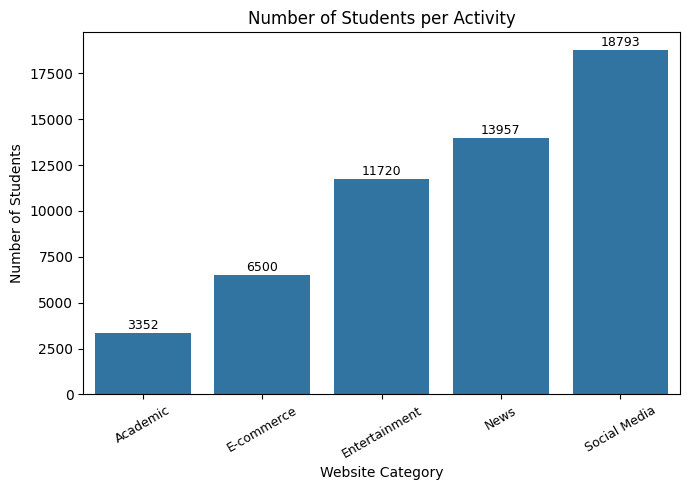

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("/content/drive/MyDrive/Student_data.csv")

categories = df['website_category'].unique()

category_weights = {
    categories[0]: 0.4,
    categories[1]: 0.25,
    categories[2]: 0.2,
    categories[3]: 0.1,
    categories[4]: 0.05
}

np.random.seed(42)
df['website_category'] = np.random.choice(
    list(category_weights.keys()),
    size=len(df),
    p=list(category_weights.values())
)

df.to_csv("/content/modified_student_data.csv", index=False)
print("Modified dataset saved as modified_student_data.csv")

activity_counts = df.groupby('website_category')['student_id'].nunique().reset_index()
activity_counts.rename(columns={'student_id': 'num_students'}, inplace=True)

plt.figure(figsize=(7,5))
ax = sns.barplot(x='website_category', y='num_students', data=activity_counts)

for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',
                (p.get_x() + p.get_width()/2., p.get_height()+50),
                ha='center', va='bottom', fontsize=9)

plt.title("Number of Students per Activity", fontsize=12)
plt.xlabel("Website Category", fontsize=10)
plt.ylabel("Number of Students", fontsize=10)
plt.xticks(rotation=30, fontsize=9)
plt.tight_layout()
plt.show()

In [ ]:
!pip install skorch

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from skorch import NeuralNetClassifier
from sklearn.metrics import accuracy_score, classification_report

np.random.seed(42)
N = 600

stability = np.random.randint(1, 10, N)
span = np.random.randint(1, 10, N)
shifting = np.random.randint(1, 10, N)
distribution = np.random.randint(1, 10, N)

performance = []
for s, sp, sh, d in zip(stability, span, shifting, distribution):
    score = 0.4*s + 0.3*sp + 0.2*sh + 0.1*d
    if score > 6.5:
        performance.append("High")
    elif score > 4.5:
        performance.append("Medium")
    else:
        performance.append("Low")

pa_features = pd.DataFrame({
    "attention_stability": stability,
    "attention_span": span,
    "attention_shifting": shifting,
    "attention_distribution": distribution,
    "performance_tier": performance
})

pa_features['stability_span_ratio'] = pa_features['attention_stability'] / (pa_features['attention_span'] + 1e-5)
pa_features['distribution_stability'] = pa_features['attention_distribution'] * pa_features['attention_stability']
pa_features['span_shifting'] = pa_features['attention_span'] * pa_features['attention_shifting']

X = pa_features.drop(columns=['performance_tier'])
y = pa_features['performance_tier']

le = LabelEncoder()
y = le.fit_transform(y)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, stratify=y, random_state=42
)

X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)

class AttentionMLP(nn.Module):
    def __init__(self, input_dim=7, hidden_dim=64, num_classes=3):
        super(AttentionMLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.dropout = nn.Dropout(0.3)
        self.attn = nn.Linear(hidden_dim, 1)
        self.fc2 = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        h = torch.relu(self.fc1(x))
        h = self.dropout(h)
        attn_weights = torch.softmax(self.attn(h), dim=0)
        h = h * attn_weights
        return self.fc2(h)

net = NeuralNetClassifier(
    AttentionMLP,
    module__input_dim=X_train.shape[1],
    module__hidden_dim=64,
    module__num_classes=len(np.unique(y)),
    max_epochs=50,
    lr=0.001,
    optimizer=optim.AdamW,
    criterion=nn.CrossEntropyLoss,
    batch_size=32,
    verbose=0,
    device='cuda' if torch.cuda.is_available() else 'cpu'
)

rf = RandomForestClassifier(n_estimators=250, random_state=42)

ensemble = VotingClassifier(
    estimators=[('rf', rf), ('mlp', net)],
    voting='soft'
)

ensemble.fit(X_train, y_train)

y_pred = ensemble.predict(X_test)
acc = accuracy_score(y_test, y_pred)

print(f"\nEnsemble Accuracy: {acc*100:.2f}%")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.5/268.5 kB 4.1 MB/s eta 0:00:00

Ensemble Accuracy: 99.17%

Classification Report:
              precision    recall  f1-score   support

        High       1.00      1.00      1.00        16
         Low       1.00      0.98      0.99        50
      Medium       0.98      1.00      0.99        54

    accuracy                           0.99       120
   macro avg       0.99      0.99      0.99       120
weighted avg       0.99      0.99      0.99       120



In [ ]:
!pip install skorch

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from skorch import NeuralNetClassifier
from sklearn.metrics import accuracy_score, classification_report
import joblib
np.random.seed(42)
N = 600
stability = np.random.randint(1, 10, N)
span = np.random.randint(1, 10, N)
shifting = np.random.randint(1, 10, N)
distribution = np.random.randint(1, 10, N)

performance = []
for s, sp, sh, d in zip(stability, span, shifting, distribution):
    score = 0.4*s + 0.3*sp + 0.2*sh + 0.1*d
    if score > 6.5:
        performance.append("High")
    elif score > 4.5:
        performance.append("Medium")
    else:
        performance.append("Low")

pa_features = pd.DataFrame({
    "attention_stability": stability,
    "attention_span": span,
    "attention_shifting": shifting,
    "attention_distribution": distribution,
    "performance_tier": performance
})

pa_features['stability_span_ratio'] = pa_features['attention_stability'] / (pa_features['attention_span'] + 1e-5)
pa_features['distribution_stability'] = pa_features['attention_distribution'] * pa_features['attention_stability']
pa_features['span_shifting'] = pa_features['attention_span'] * pa_features['attention_shifting']

X = pa_features.drop(columns=['performance_tier'])
y = pa_features['performance_tier']

le = LabelEncoder()
y = le.fit_transform(y)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, stratify=y, random_state=42
)

X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)

class AttentionMLP(nn.Module):
    def __init__(self, input_dim=7, hidden_dim=64, num_classes=3):
        super(AttentionMLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.dropout = nn.Dropout(0.3)
        self.attn = nn.Linear(hidden_dim, 1)
        self.fc2 = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        h = torch.relu(self.fc1(x))
        h = self.dropout(h)
        attn_weights = torch.softmax(self.attn(h), dim=0)
        h = h * attn_weights
        return self.fc2(h)

net = NeuralNetClassifier(
    AttentionMLP,
    module__input_dim=X_train.shape[1],
    module__hidden_dim=64,
    module__num_classes=len(np.unique(y)),
    max_epochs=50,
    lr=0.001,
    optimizer=optim.AdamW,
    criterion=nn.CrossEntropyLoss,
    batch_size=32,
    verbose=0,
    device='cuda' if torch.cuda.is_available() else 'cpu'
)

rf = RandomForestClassifier(n_estimators=250, random_state=42)

ensemble = VotingClassifier(
    estimators=[('rf', rf), ('mlp', net)],
    voting='soft'
)

ensemble.fit(X_train, y_train)
y_pred = ensemble.predict(X_test)
acc = accuracy_score(y_test, y_pred)

print(f"\nEnsemble Accuracy: {acc*100:.2f}%")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))
class ScholarshipPredictor:
    def __init__(self, model, scaler, label_encoder, feature_names):
        self.model = model
        self.scaler = scaler
        self.label_encoder = label_encoder
        self.feature_names = feature_names

    def predict_scholarship(self, student_data):
        """
        Predicts the performance tier and scholarship eligibility for new student data.

        Args:
            student_data (pd.DataFrame): DataFrame with original feature columns.
                                        e.g., ['attention_stability', 'attention_span', 'attention_shifting', 'attention_distribution']
        Returns:
            pd.DataFrame: A DataFrame with the original data, predicted tier, and scholarship status.
        """

        student_data['stability_span_ratio'] = student_data['attention_stability'] / (student_data['attention_span'] + 1e-5)
        student_data['distribution_stability'] = student_data['attention_distribution'] * student_data['attention_stability']
        student_data['span_shifting'] = student_data['attention_span'] * student_data['attention_shifting']

        try:
            student_data_reordered = student_data[self.feature_names]
        except KeyError as e:
            print(f"Error: Missing required feature in student_data: {e}")
            return None

        student_data_scaled = self.scaler.transform(student_data_reordered)
        student_data_scaled_torch = student_data_scaled.astype(np.float32)
        predicted_tier_encoded = self.model.predict(student_data_scaled_torch)
        predicted_tier = self.label_encoder.inverse_transform(predicted_tier_encoded)

        scholarship_status = []
        for tier in predicted_tier:
            if tier == "High":
                scholarship_status.append("Full Scholarship")
            elif tier == "Medium":
                scholarship_status.append("Partial Scholarship")
            else:
                scholarship_status.append("Not Eligible")

        student_data['predicted_tier'] = predicted_tier
        student_data['scholarship_status'] = scholarship_status

        return student_data

scholarship_predictor = ScholarshipPredictor(
    model=ensemble,
    scaler=scaler,
    label_encoder=le,
    feature_names=list(X.columns)
)

new_students_data = pd.DataFrame({
    "attention_stability": [9, 5, 2],
    "attention_span": [8, 6, 4],
    "attention_shifting": [9, 5, 3],
    "attention_distribution": [8, 5, 2]
})

scholarship_results = scholarship_predictor.predict_scholarship(new_students_data.copy())

if scholarship_results is not None:
    print("\n===============================================")
    print("Scholarship Eligibility for New Students")
    print("===============================================")
    print(scholarship_results[['attention_stability', 'attention_span', 'predicted_tier', 'scholarship_status']])


Ensemble Accuracy: 97.50%

Classification Report:
              precision    recall  f1-score   support

        High       1.00      0.88      0.93        16
         Low       1.00      0.98      0.99        50
      Medium       0.95      1.00      0.97        54

    accuracy                           0.97       120
   macro avg       0.98      0.95      0.97       120
weighted avg       0.98      0.97      0.97       120


Scholarship Eligibility for New Students
   attention_stability  attention_span predicted_tier   scholarship_status
0                    9               8           High     Full Scholarship
1                    5               6         Medium  Partial Scholarship
2                    2               4            Low         Not Eligible


In [ ]:
!pip install skorch

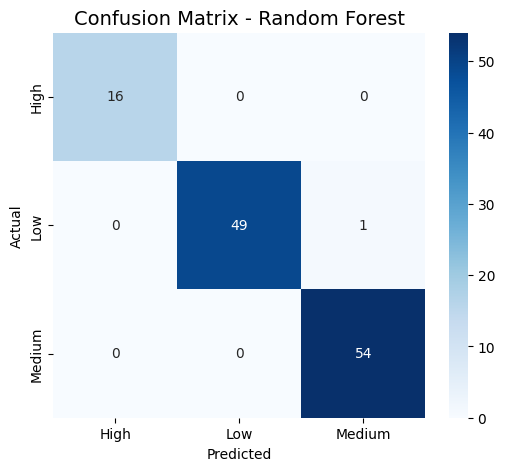

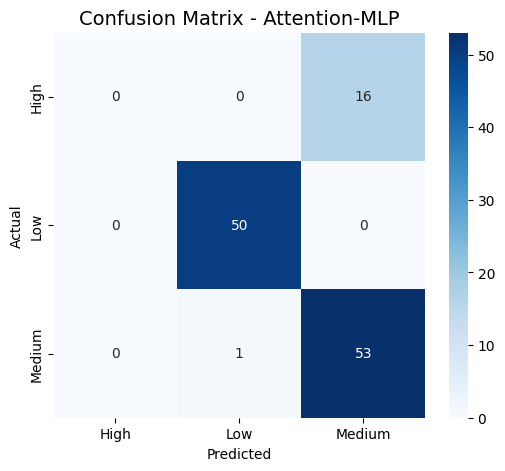

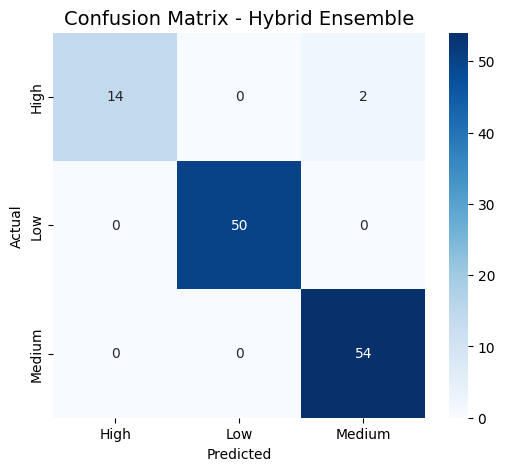

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from skorch import NeuralNetClassifier
from sklearn.metrics import accuracy_score, classification_report

np.random.seed(42)
N = 600

stability = np.random.randint(1, 10, N)
span = np.random.randint(1, 10, N)
shifting = np.random.randint(1, 10, N)
distribution = np.random.randint(1, 10, N)

performance = []
for s, sp, sh, d in zip(stability, span, shifting, distribution):
    score = 0.4*s + 0.3*sp + 0.2*sh + 0.1*d
    if score > 6.5:
        performance.append("High")
    elif score > 4.5:
        performance.append("Medium")
    else:
        performance.append("Low")

pa_features = pd.DataFrame({
    "attention_stability": stability,
    "attention_span": span,
    "attention_shifting": shifting,
    "attention_distribution": distribution,
    "performance_tier": performance
})

pa_features['stability_span_ratio'] = pa_features['attention_stability'] / (pa_features['attention_span'] + 1e-5)
pa_features['distribution_stability'] = pa_features['attention_distribution'] * pa_features['attention_stability']
pa_features['span_shifting'] = pa_features['attention_span'] * pa_features['attention_shifting']

X = pa_features.drop(columns=['performance_tier'])
y = pa_features['performance_tier']

le = LabelEncoder()
y = le.fit_transform(y)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, stratify=y, random_state=42
)

X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)

class AttentionMLP(nn.Module):
    def __init__(self, input_dim=7, hidden_dim=64, num_classes=3):
        super(AttentionMLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.dropout = nn.Dropout(0.3)
        self.attn = nn.Linear(hidden_dim, 1)
        self.fc2 = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        h = torch.relu(self.fc1(x))
        h = self.dropout(h)
        attn_weights = torch.softmax(self.attn(h), dim=0)
        h = h * attn_weights
        return self.fc2(h)

net = NeuralNetClassifier(
    AttentionMLP,
    module__input_dim=X_train.shape[1],
    module__hidden_dim=64,
    module__num_classes=len(np.unique(y)),
    max_epochs=50,
    lr=0.001,
    optimizer=optim.AdamW,
    criterion=nn.CrossEntropyLoss,
    batch_size=32,
    verbose=0,
    device='cuda' if torch.cuda.is_available() else 'cpu'
)

rf = RandomForestClassifier(n_estimators=250, random_state=42)

ensemble = VotingClassifier(
    estimators=[('rf', rf), ('mlp', net)],
    voting='soft'
)

ensemble.fit(X_train, y_train)

y_pred_ensemble = ensemble.predict(X_test)

rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

net.fit(X_train, y_train)
y_pred_net = net.predict(X_test)


def plot_conf_matrix(y_true, y_pred, labels, model_name):
    """Plots a confusion matrix heatmap for a given model."""
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels, yticklabels=labels)
    plt.title(f'Confusion Matrix - {model_name}', fontsize=14)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

plot_conf_matrix(y_test, y_pred_rf, le.classes_, "Random Forest")
plot_conf_matrix(y_test, y_pred_net, le.classes_, "Attention-MLP")
plot_conf_matrix(y_test, y_pred_ensemble, le.classes_, "Hybrid Ensemble")

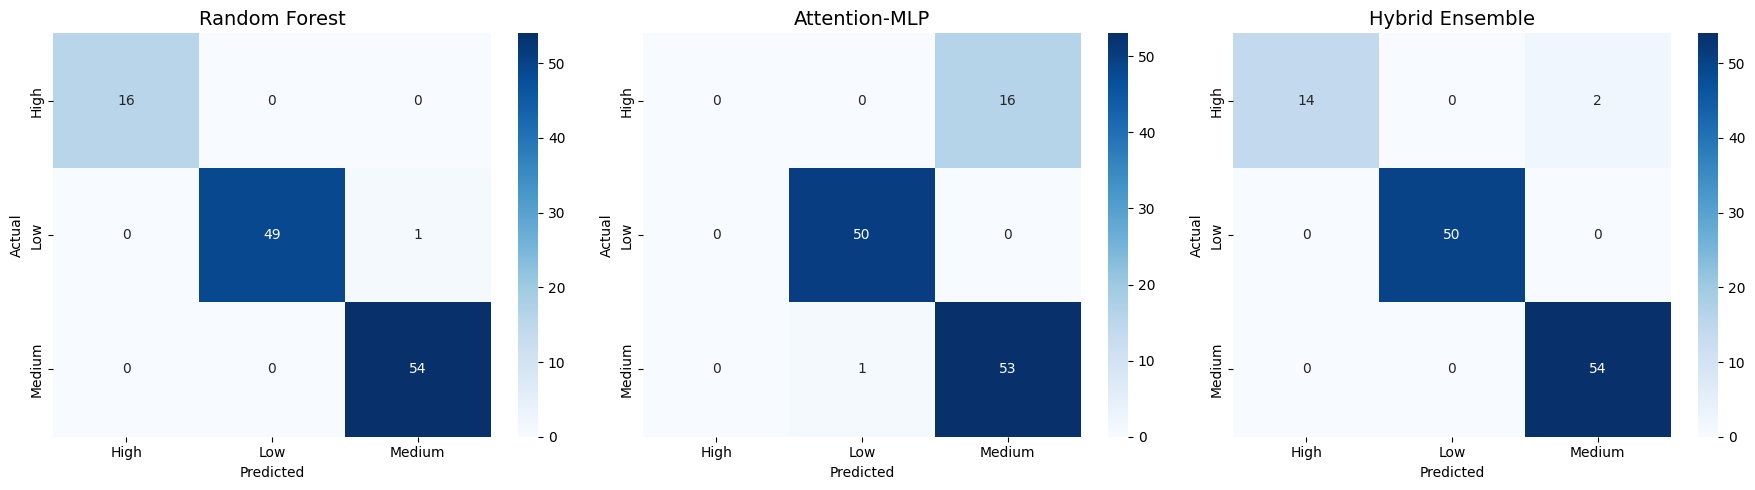

In [ ]:
def plot_conf_matrices_side_by_side(y_true, y_preds, labels, model_names):
    """Plots multiple confusion matrices side by side."""
    n_models = len(y_preds)
    fig, axes = plt.subplots(1, n_models, figsize=(6*n_models, 5))

    for i, (y_pred, name) in enumerate(zip(y_preds, model_names)):
        cm = confusion_matrix(y_true, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=labels, yticklabels=labels, ax=axes[i])
        axes[i].set_title(f'{name}', fontsize=14)
        axes[i].set_xlabel('Predicted')
        axes[i].set_ylabel('Actual')

    plt.tight_layout()
    plt.show()

plot_conf_matrices_side_by_side(
    y_test,
    [y_pred_rf, y_pred_net, y_pred_ensemble],
    le.classes_,
    ["Random Forest", "Attention-MLP", "Hybrid Ensemble"]
)